In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install contractions
!pip install git+https://github.com/allenai/longformer.git

     |████████████████████████████████| 321 kB 7.9 MB/s 
     |████████████████████████████████| 284 kB 63.5 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85442 sha256=35aa688c246b80bba8872a001d07881eb03d83d75bfeff4e8820945c42816b64
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick
  Cloning https://github.com/allenai/longformer.git to /tmp/pip-req-build-pdk0b1_q
  Running command git clone -q https://github.com/allenai/longformer.git /tmp/pip-req-build-pdk0b1_q
  Cloning http://github.com/ibeltagy/transformers.git (to revision longformer_encoder_decoder) to /tmp/pip-install-wu7_c0yr/transformers_8037a4c19f934afc9ac516c317792190
  Running command git clone -q http://github.com/ibeltagy/transformers.git /tmp/pip-install-wu7_c0yr/transformers_8037a4c19f934afc9ac516c317792190
  Running command git checkout -b longformer_encoder_decoder --track 

In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
import torch
torch.__version__

'1.9.0+cu102'

In [5]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.utils import shuffle
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import contractions
import inspect
import re
import random
import glob
import re
import matplotlib.gridspec as gridspec
import seaborn
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
df_1=pd.read_excel('/content/gdrive/MyDrive/Updated_Model_Notebooks/belltire_16_indicator/training data/Belle Tire Data for Model Training 23-08-2021.xlsx',sheet_name='Belle Tire')

In [ ]:
df_1

In [8]:
df_1.columns

Index(['Timestamp', 'Date', 'Recording', 'ConvirzaId', 'Scorer Name', 'Type',
       'Agent', 'Call Title', 'Group', 'Client Company Name', 'Industry Label',
       'Was work order written?', 'Greeting- Thank You',
       'Greeting- Agent Name', 'Greeting- Offer Help',
       'Qualifying- Assume Ownership ', 'Qualifying- Agent Empathy',
       'Qualifying- Ask about vehicle', 'Recommend- Lowest price',
       'Recommend- Lifetime benefits', 'Recommend- Features/benefits',
       'Recommend- Out the door price', 'Assuming the Visit',
       'Overcoming Objections', 'Benediction- Close with Thank you',
       'Benediction- Close with Thank you and Reinforcement',
       'Recommend- Least expensive', 'Transcript', 'Indexes',
       'Agent/Caller Transcript', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32',
       'Unnamed: 33'],
      dtype='object')

In [9]:
columns_name=['Was work order written?',
       'Greeting- Thank You', 'Greeting- Agent Name', 'Greeting- Offer Help',
       'Qualifying- Assume Ownership ', 'Qualifying- Agent Empathy',
       'Qualifying- Ask about vehicle', 'Recommend- Lowest price',
       'Recommend- Lifetime benefits', 'Recommend- Features/benefits',
       'Recommend- Out the door price', 'Assuming the Visit',
       'Overcoming Objections', 'Benediction- Close with Thank you',
       'Benediction- Close with Thank you and Reinforcement',
       'Recommend- Least expensive','Agent/Caller Transcript']

In [ ]:
df_1

In [11]:
df_3=df_1.copy()
df_3.shape

(7519, 34)

In [12]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7519 entries, 0 to 7518
Data columns (total 34 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Timestamp                                            7519 non-null   object 
 1   Date                                                 7519 non-null   object 
 2   Recording                                            7519 non-null   object 
 3   ConvirzaId                                           7519 non-null   int64  
 4   Scorer Name                                          7519 non-null   object 
 5   Type                                                 7519 non-null   object 
 6   Agent                                                4966 non-null   object 
 7   Call Title                                           7519 non-null   object 
 8   Group                                                5754 non-null  

## Data cleaning

In [13]:
import re
import os
from longformer.longformer import Longformer, LongformerConfig
from transformers import LongformerTokenizer, LongformerForSequenceClassification
from longformer.sliding_chunks import pad_to_window_size
from transformers import RobertaTokenizer
#config = LongformerConfig.from_pretrained('/content/gdrive/MyDrive/longformer-base-4096/')

MAX_LEN=1024
tokenizer=LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')

def pre_process(text):
  fillerWord = ("so","yeah","okay","um","uh","mmm","ahan","uh","huh","ahm","oh","sooo","uh","huh","yeh","yah","hmm","bye")
  fillerword_reg= "bye[.,]|so[.,]|yeah[.,]|okay[.,]|um[.,]|uh[.,]|mmm[.,]|ahan[.,]|uh[.,]|huh[.,]|ahm[.,]|oh[.,]|sooo[.,]|uh[.,]|huh[.,]|yeh[.,]|yah[.,]|hmm[.,]"
  # STOPWORDS = set(stopwords.words('english'))
  #STOPWORDS.add(fillerWord)  
  STOPWORDS=fillerWord
 
  # that's, we'll, can't ...
  text=contractions.fix(text,slang=False)
  text=text.replace(':',' ')
  # that is, we will, can not ...
  text=' '.join(word for word in text.lower().split() if word not in STOPWORDS)
  filler=re.compile(fillerword_reg)
  text=filler.sub("",text)
  # text_sw.append(contractions.fix(i.lower(),slang=False))
  return text

class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.comment_text.values.tolist()
        #self.targets = self.data.list
        self.targets = self.data['list'].values.tolist()
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)
    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True,return_tensors="pt"
        )
        ids = inputs['input_ids'].to(device)
        mask = inputs['attention_mask'].to(device)
        token_type_ids = inputs["token_type_ids"].to(device)


        return {
            'ids': ids,
            'mask': mask,
            'token_type_ids': token_type_ids,
            'targets': torch.tensor(self.targets[index], dtype=torch.long).to(device)
        }

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [14]:
label_conversion={'Was work order written?':0,
       'Greeting- Thank You':1, 'Greeting- Agent Name':2, 'Greeting- Offer Help':3,
       'Qualifying- Assume Ownership ':4, 'Qualifying- Agent Empathy':5,
       'Qualifying- Ask about vehicle':6, 'Recommend- Lowest price':7,
       'Recommend- Lifetime benefits':8, 'Recommend- Features/benefits':9,
       'Recommend- Out the door price':10, 'Assuming the Visit':11,
       'Overcoming Objections':12, 'Benediction- Close with Thank you':13,
       'Benediction- Close with Thank you and Reinforcement':14,
       'Recommend- Least expensive':15,'Agent/Caller Transcript':'Agent/Caller Transcript'}
a=list(label_conversion.values())
print(a)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 'Agent/Caller Transcript']


In [15]:
def training_data_s3(training_dir=''):
    column_slection=['Was work order written?',
       'Greeting- Thank You', 'Greeting- Agent Name', 'Greeting- Offer Help',
       'Qualifying- Assume Ownership ', 'Qualifying- Agent Empathy',
       'Qualifying- Ask about vehicle', 'Recommend- Lowest price',
       'Recommend- Lifetime benefits', 'Recommend- Features/benefits',
       'Recommend- Out the door price', 'Assuming the Visit',
       'Overcoming Objections', 'Benediction- Close with Thank you',
       'Benediction- Close with Thank you and Reinforcement',
       'Recommend- Least expensive','Agent/Caller Transcript']
    data =df_3[column_slection]
    print(data.shape)
    data=data.dropna(subset=["Agent/Caller Transcript"]) # drop rows where transcript == "" or nan
    print('data shape: ',data.shape)
    duplicates = data[data['Agent/Caller Transcript'].duplicated() == True].index #Remove duplicates based on transcript
    data.drop(index=duplicates, inplace=True, axis=0)
    print('data shape after removing duplicates : ',data.shape)
    data=data[data['Qualifying- Assume Ownership '].notna()].reset_index()
    del data['index']
    data.columns=label_conversion.values()
    data=data
    return data

def _get_data_loader(batch_size, training_dir,is_distributed=False):
    data=training_data_s3(training_dir)
    data=data.dropna(subset=["Agent/Caller Transcript"]) # drop rows where transcript == "" or nan
    columns_label=list(label_conversion.values())
    columns_label=columns_label[:-1]
    print("columns_label",columns_label)
    print("columns_label len",len(columns_label))
    labels=data[columns_label]
    labels=labels.values.tolist()
    text=data["Agent/Caller Transcript"]
    text_sw=[]
    lengths_sw=[]
    for i in text.values.tolist():
      text = pre_process(i)
      text_sw.append(text)
      lengths_sw.append(len(text.split()))

    lengths_sw=np.asarray(lengths_sw)
    indexes_lt_1 = np.where (lengths_sw<=512)
   
    # print('indexes_lt_1',indexes_lt_1)
    text_new_1 = np.asarray(text_sw)[indexes_lt_1[0]]
    labels_new_1 = np.asarray(labels)[indexes_lt_1[0]]

    indexes_lt_2 = np.where (lengths_sw > 512)
    text_new_2 = np.asarray(text_sw)[indexes_lt_2[0]]
    labels_new_2 = np.asarray(labels)[indexes_lt_2[0]]

    modulo = len(text_new_1) % batch_size
    # print('modulo:',modulo)
    size=batch_size - modulo
    # print('size=batch_size - modulo:',size)
    rand_indexes = np.random.randint(len(text_new_1), size=batch_size - modulo)
    # print(rand_indexes)
    filler_text_1 = text_new_1[rand_indexes]
    filler_labels_1 = labels_new_1[rand_indexes]
    # print(len(text_new_1))
    # modulo = len(text_new_2) % batch_size
    rand_indexes = np.random.randint(len(text_new_2), size=batch_size - modulo)
    filler_text_2 = text_new_2[rand_indexes]
    filler_labels_2 = labels_new_2[rand_indexes]
    text_new_1 = np.concatenate([text_new_1, filler_text_1])
    labels_new_1 = np.concatenate([labels_new_1, filler_labels_1])
    # print(len(text_new_1))
    text_new_2 = np.concatenate([text_new_2, filler_text_2])
    labels_new_2 = np.concatenate([labels_new_2, filler_labels_2])
    
    text_new_1 = list(text_new_1)
    labels_new_1 = list(labels_new_1)

    text_new_2 = list(text_new_2)
    labels_new_2 = list(labels_new_2)

    new_df1 = pd.DataFrame({'comment_text':text_new_1, 'list':labels_new_1})
    train_samples1 = np.ceil((new_df1.shape[0]/batch_size)*0.8)
    train_dataset1 = new_df1.sample(n=int(train_samples1*batch_size),random_state=200)
    test_dataset1 = new_df1.drop(train_dataset1.index).reset_index(drop=True)
    #print( test_dataset1['comment_text'][0])
    
    new_df2 = pd.DataFrame({'comment_text':text_new_2, 'list':labels_new_2})
    train_samples2 = np.ceil((new_df2.shape[0]/batch_size)*0.8)
    # print('train_samples2',train_samples2)
    train_dataset2 = new_df2.sample(n=int(train_samples2*batch_size),random_state=200)
    test_dataset2 = new_df2.drop(train_dataset2.index).reset_index(drop=True)
    print (train_samples2, test_dataset2.shape)
    #print( test_dataset1['comment_text'][0])
    test_dataset = pd.concat([test_dataset1,test_dataset2], ignore_index=True,axis=0).reset_index(drop=True)
    train_dataset = pd.concat([train_dataset1,train_dataset2], ignore_index=True,axis=0).reset_index(drop=True)

    print("TRAIN Dataset: {}".format(train_dataset.shape))
    print("TEST Dataset: {}".format(test_dataset.shape))
    print (test_dataset.head(5))
    test_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)
    training_set=CustomDataset(train_dataset,tokenizer,MAX_LEN)
    
    if is_distributed:
        test_sampler = torch.utils.data.distributed.DistributedSampler(test_set)
        test_dataloader = DataLoader(test_set, sampler=test_sampler, batch_size=batch_size,drop_last=True)
        train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset)
        train_dataloader = DataLoader(training_set, sampler=train_sampler, batch_size=batch_size,drop_last=True)
    else:
        test_dataloader = DataLoader(test_set, shuffle=False, batch_size=batch_size,drop_last=True)
        train_dataloader = DataLoader(training_set, shuffle=False, batch_size=batch_size,drop_last=True)
    return test_dataloader,test_dataset,train_dataloader,train_dataset

# DataLoader

In [16]:
s3_data=training_data_s3(training_dir='')

(7519, 17)
data shape:  (7515, 17)
data shape after removing duplicates :  (7374, 17)


In [17]:
testing_loader,test_dataset,train_loader,train_dataset = _get_data_loader(4,training_dir='')

(7519, 17)
data shape:  (7515, 17)
data shape after removing duplicates :  (7374, 17)
columns_label [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
columns_label len 16
722.0 (720, 2)
TRAIN Dataset: (5908, 2)
TEST Dataset: (1472, 2)
                                        comment_text                                              list
0  agent this call may be monitored and recorded ...  [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1]
1  agent this call may be monitored and recorded ...  [0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1]
2  agent this call may be monitored and recorded ...  [0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0]
3  agent this call may be monitored and recorded ...  [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1]
4  agent this call may be monitored and recorded ...  [0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]


In [18]:
y = iter(testing_loader).next()
y["targets"].shape

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


torch.Size([4, 16])

In [19]:
y["ids"].shape, y["mask"].shape,y["targets"].shape

(torch.Size([4, 1, 1024]), torch.Size([4, 1, 1024]), torch.Size([4, 16]))

In [20]:
import tarfile
import requests
from longformer.longformer import LongformerConfig

#download longformer-base-4096.tar.gz 
fname = 'longformer-base-4096.tar.gz'
url = 'https://ai2-s2-research.s3-us-west-2.amazonaws.com/longformer/' + fname
r = requests.get(url)
open(fname , 'wb').write(r.content)
# longformer-base-4096.tar.gz 
tar = tarfile.open(fname)
tar.extractall()
tar.close()

config = LongformerConfig.from_pretrained('longformer-base-4096/') 
config.attention_mode = 'sliding_chunks'
# config.attention_window=window_size

In [21]:
# BERTClass and model creation
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = Longformer.from_pretrained('longformer-base-4096/', config=config)
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 16)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

BERTClass(
  (l1): Longformer(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
              (value_global): Linear(in_features=768, out_features=768, bias=T

In [22]:
# loss function
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [23]:
LEARNING_RATE=1e-05
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [24]:
import time
from sklearn.metrics import classification_report
import pprint

In [25]:
#def plotCurves(stats, path, f1=False):
def plotCurves(stats, f1=False):
    fig = plt.figure(constrained_layout=True)
    spec2 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
    ax1 = fig.add_subplot(spec2[0, 0])
    ax2 = fig.add_subplot(spec2[0, 1])
    ax3 = fig.add_subplot(spec2[1, 0])
    for i in ['train_loss', 'valid_loss']: 
      ax1.plot(stats[i], label=i)
    ax1.legend()
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')

    for j in ['train_acc', 'valid_acc']: 
      ax2.plot(100 * stats[j], label=j)
    ax2.legend()
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    
    if f1:
        for c in ['train_f1', 'valid_f1']: 
          ax3.plot(stats[c], label=c)
        ax3.legend()
        ax3.set_xlabel('Epochs')
        ax3.set_ylabel('F1 Score')
    fig.savefig(basePath+'curve.png')
        
    #fig.savefig(path+'/Metrics.png')

In [26]:
def CallsTrain(Model, trainloader, testloader, Epochs, name):  
    stats = []
    old_loss=1000
    bad_epoch_count=0
    for epoch in range(1, Epochs):  # loop over the dataset multiple times
        train_loss, running_loss = 0.0, 0.0
        valid_loss, val_loss = 0.0, 0.0
        t_accuracy, v_accuracy = [], []
        t_f1, v_f1 = [], []
        Model.train()
        cls_preds, cls_tars = [], [] 
        fin_targets,fin_outputs=[],[]
        v_fin_targets,v_fin_outputs=[],[]
        tr_pbar = tqdm(enumerate(trainloader, 0)) 
        for tr_batch, data in tr_pbar:    # Getting the batches every iteration
            tr_pbar.set_description(f'Epoch no: {epoch}/{Epochs} Training batch no {tr_batch}')
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            try:
                outputs = Model(ids.squeeze(), mask.squeeze(), token_type_ids.squeeze())
            except Exception as ex:
                print('exception in here',ex)
                #print('the exception','id',type(ids),'mask',type(mask),'token_type_ids',type(token_type_ids), 'targets',type(targets),ex)
            optimizer.zero_grad()
            loss = loss_fn(outputs, targets)
            loss.backward()                     #----> backward pass
            optimizer.step()                   #----> weights update

            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
            running_loss += loss       # Adding loss for every batch size
        train_loss = running_loss / len(trainloader)
        outputs=np.asarray(fin_outputs)
        targets=np.asarray(fin_targets)
        #print(outputs,targets)
        outputs = outputs >= 0.5
        from sklearn.metrics import accuracy_score
        epoch_acc = accuracy_score(targets, outputs)
        epoch_f1 = metrics.f1_score(targets, outputs, average='macro')
        epoch_Recall = metrics.recall_score(targets, outputs,average='macro')
        epoch_Precision = metrics.precision_score(targets, outputs,average='macro')

        Model.eval()
        with torch.no_grad():
            val_pbar = tqdm(enumerate(testloader, 0)) 
            for val_batch, v_data in val_pbar:
                val_pbar.set_description(f'Epoch no: {epoch}/{Epochs} Validation batch no {val_batch}')
                ids = v_data['ids'].to(device, dtype = torch.long)
                mask = v_data['mask'].to(device, dtype = torch.long)
                token_type_ids = v_data['token_type_ids'].to(device, dtype = torch.long)
                targets = v_data['targets'].to(device, dtype = torch.float)
                try:
                    outputs = Model(ids.squeeze(), mask.squeeze(), token_type_ids.squeeze())
                except Exception as ex:
                    print('exception in here',ex)

                v_loss = loss_fn(outputs, targets)
                v_fin_targets.extend(targets.cpu().detach().numpy().tolist())
                v_fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
                val_loss += v_loss        # Adding loss for every batch size
            valid_loss = val_loss / len(testloader)
            outputs=np.asarray(v_fin_outputs)
            targets=np.asarray(v_fin_targets)
            #print(outputs.shape,targets.shape)
            outputs = outputs >= 0.5
            from sklearn.metrics import accuracy_score
            epoch_vacc = accuracy_score(targets, outputs)
            epoch_vf1 = metrics.f1_score(targets, outputs, average='macro')
            epoch_vRecall = metrics.recall_score(targets, outputs,average='macro')
            epoch_vPrecision = metrics.precision_score(targets, outputs,average='macro')

            #print(f'\nTraining loss: {train_loss}, Training Accuracy: {100*epoch_acc}, Training F1 Score: {epoch_f1}')
            print(f'\nTraining loss: {train_loss}, Training Accuracy: {epoch_acc}, Training F1 Score: {epoch_f1}')
            print(f'Validation loss: {valid_loss}, Validation Accuracy: {epoch_vacc}, Validation F1 Score: {epoch_vf1}')
            print(f'Validation Precision: {epoch_vPrecision}, Validation Recall: {epoch_vRecall}')
            print(f'Training Precision: {epoch_Precision}, Training Recall: {epoch_Recall}')

            from sklearn.metrics import classification_report
            target_names = ['class 0', 'class 1', 'class 2','class 3', 'class 4', 'class 5','class 6', 'class 7', 'class 8','class 9',
                            'class 10', 'class 11','class 12', 'class 13', 'class 14','class 15']

            print('validation classification report',classification_report(targets, outputs, target_names=target_names))
            stats.append([train_loss, valid_loss, epoch_acc, epoch_vacc, epoch_f1, epoch_vf1])
            history = pd.DataFrame(stats, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc', 'train_f1', 'valid_f1'])
            if old_loss>valid_loss:
                  old_loss=valid_loss
                  torch.save(Model.state_dict(), name)
                  bad_epoch_count=0
                  print('Model saved after ',epoch,' epochs')
            else:
                  bad_epoch_count+=1
                  print('Number of bad epochs: ',bad_epoch_count,'\nModel not saved')
                  if bad_epoch_count==5:
                      print('Training Process Stopped due to 5 bad epochs and history/plot updated')
                      history.to_csv(basePath+"history.csv")
                      plotCurves(history,True)
                      break
            history.to_csv(basePath+"history.csv")
            #if epoch % 5 == 0: plotCurves(history, '/content/drive/MyDrive/customer-name-email-phone-number-extacion/all_4691_calls_agent_caller_phone_data/longformer/', True)
            if epoch % 5 == 0: plotCurves(history,True)
                    
    return Model, history

In [27]:
print('running ')

running 


In [28]:
basePath='/content/gdrive/MyDrive/Updated_Model_Notebooks/belltire_16_indicator/trained models/'

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Epoch no: 1/20 Training batch no 1476: : 1477it [23:50,  1.03it/s]
Epoch no: 1/20 Validation batch no 367: : 368it [01:35,  3.83it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.


Training loss: 0.3952690660953522, Training Accuracy: 0.07092078537576169, Training F1 Score: 0.7064205076679615
Validation loss: 0.3426070213317871, Validation Accuracy: 0.10326086956521739, Validation F1 Score: 0.7495914759431537
Validation Precision: 0.7161992883452624, Validation Recall: 0.790291253188016
Training Precision: 0.7319882835322623, Training Recall: 0.7076336845442394
validation classification report               precision    recall  f1-score   support

     class 0       0.91      0.94      0.93       562
     class 1       0.88      1.00      0.94      1302
     class 2       0.96      1.00      0.98      1420
     class 3       0.96      1.00      0.98      1413
     class 4       0.67      0.79      0.73       877
     class 5       0.00      0.00      0.00         2
     class 6       0.69      0.96      0.80       976
     class 7       0.85      0.90      0.88       472
     class 8       0.92      0.95      0.93       691
     class 9       0.81      0.90     

Epoch no: 2/20 Training batch no 1476: : 1477it [23:48,  1.03it/s]
Epoch no: 2/20 Validation batch no 367: : 368it [01:35,  3.84it/s]



Training loss: 0.31801408529281616, Training Accuracy: 0.11797562626946513, Training F1 Score: 0.7673656615569049
Validation loss: 0.3131292164325714, Validation Accuracy: 0.1297554347826087, Validation F1 Score: 0.764439380065883
Validation Precision: 0.7814608779266665, Validation Recall: 0.7902681804162262
Training Precision: 0.7639849436798394, Training Recall: 0.7899954294081826
validation classification report               precision    recall  f1-score   support

     class 0       0.93      0.94      0.94       562
     class 1       0.88      1.00      0.94      1302
     class 2       0.96      1.00      0.98      1420
     class 3       0.96      1.00      0.98      1413
     class 4       0.74      0.70      0.72       877
     class 5       0.00      0.00      0.00         2
     class 6       0.72      0.89      0.80       976
     class 7       0.87      0.91      0.89       472
     class 8       0.95      0.96      0.95       691
     class 9       0.86      0.91     

Epoch no: 3/20 Training batch no 1476: : 1477it [23:49,  1.03it/s]
Epoch no: 3/20 Validation batch no 367: : 368it [01:35,  3.84it/s]



Training loss: 0.28988584876060486, Training Accuracy: 0.15758293838862558, Training F1 Score: 0.7981319134011352
Validation loss: 0.2989809811115265, Validation Accuracy: 0.16576086956521738, Validation F1 Score: 0.8030564006566763
Validation Precision: 0.798081688280013, Validation Recall: 0.8143828929123209
Training Precision: 0.7918176933633692, Training Recall: 0.815609547169336
validation classification report               precision    recall  f1-score   support

     class 0       0.92      0.95      0.93       562
     class 1       0.88      1.00      0.94      1302
     class 2       0.96      1.00      0.98      1420
     class 3       0.96      1.00      0.98      1413
     class 4       0.76      0.69      0.72       877
     class 5       0.00      0.00      0.00         2
     class 6       0.85      0.81      0.83       976
     class 7       0.89      0.89      0.89       472
     class 8       0.94      0.96      0.95       691
     class 9       0.87      0.89     

Epoch no: 4/20 Training batch no 1476: : 1477it [23:49,  1.03it/s]
Epoch no: 4/20 Validation batch no 367: : 368it [01:35,  3.84it/s]



Training loss: 0.2668020725250244, Training Accuracy: 0.1909275558564658, Training F1 Score: 0.8232478364020208
Validation loss: 0.29520681500434875, Validation Accuracy: 0.1671195652173913, Validation F1 Score: 0.8090720315181312
Validation Precision: 0.8051789699057255, Validation Recall: 0.8178764318905019
Training Precision: 0.8104936591334524, Training Recall: 0.8398218202490937
validation classification report               precision    recall  f1-score   support

     class 0       0.92      0.95      0.93       562
     class 1       0.88      1.00      0.94      1302
     class 2       0.96      1.00      0.98      1420
     class 3       0.96      1.00      0.98      1413
     class 4       0.77      0.70      0.73       877
     class 5       0.00      0.00      0.00         2
     class 6       0.87      0.86      0.86       976
     class 7       0.88      0.90      0.89       472
     class 8       0.94      0.96      0.95       691
     class 9       0.86      0.90     

Epoch no: 5/20 Training batch no 1476: : 1477it [23:48,  1.03it/s]
Epoch no: 5/20 Validation batch no 367: : 368it [01:35,  3.84it/s]



Training loss: 0.2487485110759735, Training Accuracy: 0.22579553148273526, Training F1 Score: 0.8354282862261948
Validation loss: 0.2938646674156189, Validation Accuracy: 0.18138586956521738, Validation F1 Score: 0.8155193229512209
Validation Precision: 0.8042832044011078, Validation Recall: 0.8299856884414037
Training Precision: 0.8211368903554361, Training Recall: 0.8525265254823179
validation classification report               precision    recall  f1-score   support

     class 0       0.91      0.95      0.93       562
     class 1       0.88      1.00      0.94      1302
     class 2       0.96      1.00      0.98      1420
     class 3       0.96      1.00      0.98      1413
     class 4       0.77      0.72      0.75       877
     class 5       0.00      0.00      0.00         2
     class 6       0.86      0.86      0.86       976
     class 7       0.89      0.90      0.90       472
     class 8       0.95      0.96      0.95       691
     class 9       0.85      0.92    

Epoch no: 6/20 Training batch no 1476: : 1477it [23:49,  1.03it/s]
Epoch no: 6/20 Validation batch no 367: : 368it [01:35,  3.84it/s]



Training loss: 0.23261408507823944, Training Accuracy: 0.26134055517941773, Training F1 Score: 0.8451279311759137
Validation loss: 0.29529133439064026, Validation Accuracy: 0.1956521739130435, Validation F1 Score: 0.8139027673754082
Validation Precision: 0.8075924781671318, Validation Recall: 0.8230693509811611
Training Precision: 0.8311604391615888, Training Recall: 0.8612975116670216
validation classification report               precision    recall  f1-score   support

     class 0       0.91      0.94      0.93       562
     class 1       0.88      1.00      0.94      1302
     class 2       0.96      1.00      0.98      1420
     class 3       0.96      1.00      0.98      1413
     class 4       0.81      0.72      0.76       877
     class 5       0.00      0.00      0.00         2
     class 6       0.87      0.87      0.87       976
     class 7       0.91      0.90      0.91       472
     class 8       0.94      0.96      0.95       691
     class 9       0.85      0.90   

Epoch no: 7/20 Training batch no 1476: : 1477it [23:49,  1.03it/s]
Epoch no: 7/20 Validation batch no 367: : 368it [01:35,  3.84it/s]



Training loss: 0.2137620598077774, Training Accuracy: 0.28622207176709547, Training F1 Score: 0.8548755721780064
Validation loss: 0.2909663915634155, Validation Accuracy: 0.22010869565217392, Validation F1 Score: 0.8192491936762939
Validation Precision: 0.8104242812046292, Validation Recall: 0.8315357126226801
Training Precision: 0.8418308302813112, Training Recall: 0.8699654288547273
validation classification report               precision    recall  f1-score   support

     class 0       0.91      0.94      0.93       562
     class 1       0.88      1.00      0.94      1302
     class 2       0.96      1.00      0.98      1420
     class 3       0.96      1.00      0.98      1413
     class 4       0.87      0.79      0.83       877
     class 5       0.00      0.00      0.00         2
     class 6       0.86      0.89      0.87       976
     class 7       0.91      0.92      0.91       472
     class 8       0.95      0.96      0.95       691
     class 9       0.86      0.89    

Epoch no: 8/20 Training batch no 1476: : 1477it [23:48,  1.03it/s]
Epoch no: 8/20 Validation batch no 367: : 368it [01:35,  3.84it/s]



Training loss: 0.19583825767040253, Training Accuracy: 0.3324306025727827, Training F1 Score: 0.8632281237398229
Validation loss: 0.2966972589492798, Validation Accuracy: 0.21875, Validation F1 Score: 0.8120889065818405
Validation Precision: 0.8062208169033985, Validation Recall: 0.8242698049296735
Training Precision: 0.8511050505054993, Training Recall: 0.87725197592574
validation classification report               precision    recall  f1-score   support

     class 0       0.91      0.95      0.93       562
     class 1       0.88      1.00      0.94      1302
     class 2       0.96      1.00      0.98      1420
     class 3       0.96      1.00      0.98      1413
     class 4       0.89      0.85      0.87       877
     class 5       0.00      0.00      0.00         2
     class 6       0.85      0.89      0.87       976
     class 7       0.88      0.92      0.90       472
     class 8       0.94      0.96      0.95       691
     class 9       0.84      0.91      0.87       7

Epoch no: 9/20 Training batch no 1476: : 1477it [23:49,  1.03it/s]
Epoch no: 9/20 Validation batch no 367: : 368it [01:35,  3.84it/s]



Training loss: 0.17940574884414673, Training Accuracy: 0.36780636425186186, Training F1 Score: 0.8718239420369003
Validation loss: 0.3027099370956421, Validation Accuracy: 0.21739130434782608, Validation F1 Score: 0.8181269740433904
Validation Precision: 0.8072005280987457, Validation Recall: 0.8340418540061144
Training Precision: 0.8611249524816948, Training Recall: 0.884143735121068
validation classification report               precision    recall  f1-score   support

     class 0       0.90      0.94      0.92       562
     class 1       0.88      1.00      0.94      1302
     class 2       0.96      1.00      0.98      1420
     class 3       0.96      1.00      0.98      1413
     class 4       0.90      0.86      0.88       877
     class 5       0.00      0.00      0.00         2
     class 6       0.86      0.89      0.87       976
     class 7       0.90      0.92      0.91       472
     class 8       0.92      0.96      0.94       691
     class 9       0.85      0.92    

Epoch no: 10/20 Training batch no 1476: : 1477it [23:49,  1.03it/s]
Epoch no: 10/20 Validation batch no 367: : 368it [01:35,  3.83it/s]



Training loss: 0.16305036842823029, Training Accuracy: 0.40809072444143535, Training F1 Score: 0.880280614401911
Validation loss: 0.30637550354003906, Validation Accuracy: 0.20991847826086957, Validation F1 Score: 0.8211317931041558
Validation Precision: 0.8035543106478663, Validation Recall: 0.841701197930912
Training Precision: 0.8699510707948159, Training Recall: 0.8921563665182886
validation classification report               precision    recall  f1-score   support

     class 0       0.90      0.95      0.92       562
     class 1       0.88      1.00      0.94      1302
     class 2       0.96      1.00      0.98      1420
     class 3       0.96      1.00      0.98      1413
     class 4       0.88      0.88      0.88       877
     class 5       0.00      0.00      0.00         2
     class 6       0.84      0.91      0.88       976
     class 7       0.90      0.92      0.91       472
     class 8       0.95      0.95      0.95       691
     class 9       0.84      0.92    

Epoch no: 11/20 Training batch no 1476: : 1477it [23:50,  1.03it/s]
Epoch no: 11/20 Validation batch no 367: : 368it [01:36,  3.83it/s]



Training loss: 0.15013767778873444, Training Accuracy: 0.43940419769803657, Training F1 Score: 0.8847051873960927
Validation loss: 0.3127412497997284, Validation Accuracy: 0.2078804347826087, Validation F1 Score: 0.8172616913802491
Validation Precision: 0.8065272760871819, Validation Recall: 0.8316806083078574
Training Precision: 0.8751679267063568, Training Recall: 0.8955067229587823
validation classification report               precision    recall  f1-score   support

     class 0       0.90      0.95      0.92       562
     class 1       0.88      1.00      0.94      1302
     class 2       0.96      1.00      0.98      1420
     class 3       0.96      1.00      0.98      1413
     class 4       0.84      0.90      0.87       877
     class 5       0.00      0.00      0.00         2
     class 6       0.87      0.85      0.86       976
     class 7       0.89      0.92      0.90       472
     class 8       0.95      0.95      0.95       691
     class 9       0.87      0.89    

Epoch no: 12/20 Training batch no 1476: : 1477it [23:49,  1.03it/s]
Epoch no: 12/20 Validation batch no 367: : 368it [01:35,  3.84it/s]



Training loss: 0.13573427498340607, Training Accuracy: 0.481719702098849, Training F1 Score: 0.8908891831033294
Validation loss: 0.32613930106163025, Validation Accuracy: 0.21942934782608695, Validation F1 Score: 0.8231508568911519
Validation Precision: 0.7961274216772676, Validation Recall: 0.855086524688069
Training Precision: 0.882399605556434, Training Recall: 0.900537593630743
validation classification report               precision    recall  f1-score   support

     class 0       0.88      0.96      0.92       562
     class 1       0.88      1.00      0.94      1302
     class 2       0.96      1.00      0.98      1420
     class 3       0.96      1.00      0.98      1413
     class 4       0.86      0.89      0.87       877
     class 5       0.00      0.00      0.00         2
     class 6       0.85      0.88      0.86       976
     class 7       0.88      0.93      0.91       472
     class 8       0.95      0.95      0.95       691
     class 9       0.83      0.94      0

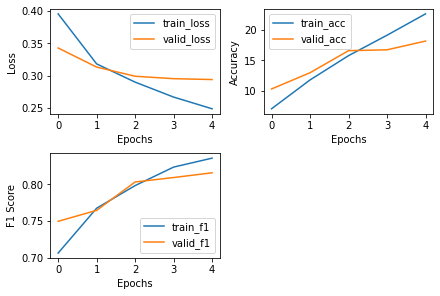

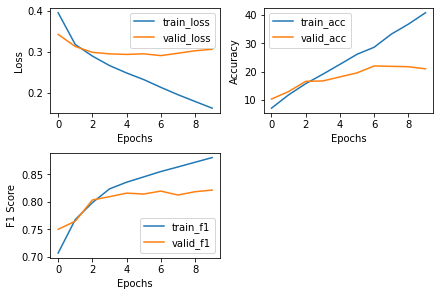

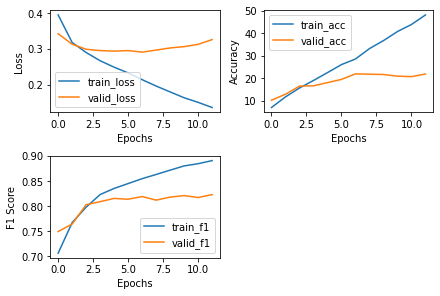

In [29]:
model, history = CallsTrain(model,train_loader, testing_loader, Epochs = 20, name = basePath+'github_longfomer_multilabel_classification.pt')